https://www.youtube.com/watch?v=UU1WVnMk4E8&t=3976s

and 

https://www.youtube.com/watch?v=kCc8FmEb1nY&t=660s

In [23]:
# Start by importing necessary libraries
import numpy as np
import time 
from tqdm import tqdm

import torch 
import torch.nn as nn
import torch.nn.functional as F

# Check for cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Setting two important hyperparameters
block_size = 8
batch_size = 4

cuda


### Step 1: Looking at the text file

In [2]:
with open('The_Great_Gatsby.txt', 'r', encoding='utf-8') as file:
    txt_file = file.read()
print(len(txt_file))

270153


### Step 2: Construct a vocabulary

In [3]:
# Get unique characters
chars = sorted(set(txt_file))
print(chars)
vocabulary_size = len(chars)
print('Total number of unique characters/Vocabulary size:', vocabulary_size)

['\n', ' ', '!', '$', '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ç', 'é', 'ê', 'ô', '\u200a', '—', '‘', '’', '“', '”', '…', '\ufeff']
Total number of unique characters/Vocabulary size: 88


In [4]:
print(list(enumerate(chars)))

[(0, '\n'), (1, ' '), (2, '!'), (3, '$'), (4, '('), (5, ')'), (6, '*'), (7, ','), (8, '-'), (9, '.'), (10, '0'), (11, '1'), (12, '2'), (13, '3'), (14, '4'), (15, '5'), (16, '6'), (17, '7'), (18, '8'), (19, '9'), (20, ':'), (21, ';'), (22, '?'), (23, 'A'), (24, 'B'), (25, 'C'), (26, 'D'), (27, 'E'), (28, 'F'), (29, 'G'), (30, 'H'), (31, 'I'), (32, 'J'), (33, 'K'), (34, 'L'), (35, 'M'), (36, 'N'), (37, 'O'), (38, 'P'), (39, 'Q'), (40, 'R'), (41, 'S'), (42, 'T'), (43, 'U'), (44, 'V'), (45, 'W'), (46, 'X'), (47, 'Y'), (48, '['), (49, ']'), (50, 'a'), (51, 'b'), (52, 'c'), (53, 'd'), (54, 'e'), (55, 'f'), (56, 'g'), (57, 'h'), (58, 'i'), (59, 'j'), (60, 'k'), (61, 'l'), (62, 'm'), (63, 'n'), (64, 'o'), (65, 'p'), (66, 'q'), (67, 'r'), (68, 's'), (69, 't'), (70, 'u'), (71, 'v'), (72, 'w'), (73, 'x'), (74, 'y'), (75, 'z'), (76, 'ç'), (77, 'é'), (78, 'ê'), (79, 'ô'), (80, '\u200a'), (81, '—'), (82, '‘'), (83, '’'), (84, '“'), (85, '”'), (86, '…'), (87, '\ufeff')]


### Step 3: Characterwise tokensiation

In [5]:
# Create encoder and decoder for characterwise tokenisation
string_to_int = {
    ch:i for i,ch in enumerate(chars)
}

int_to_string = {
    i:ch for i,ch in enumerate(chars)
}

charwise_encoder = lambda input_word: [string_to_int[char] for char in input_word]
charwise_decoder = lambda input_tokenised_word: ''.join([int_to_string[i] for i in input_tokenised_word])

In [6]:
# Experimenting with tokeniser
encoded_Jagjit_Singh = charwise_encoder('Jagjit Singh')
print(encoded_Jagjit_Singh)

[32, 50, 56, 59, 58, 69, 1, 41, 58, 63, 56, 57]


In [7]:
decoded_Jagjit_Singh = charwise_decoder(encoded_Jagjit_Singh)
print(decoded_Jagjit_Singh)

Jagjit Singh


In [9]:
# Convert the txt_file from array/list to tensor
data = torch.tensor(charwise_encoder(txt_file), dtype=torch.long)
print(data[:50])

tensor([87, 31, 63,  1, 62, 74,  1, 74, 64, 70, 63, 56, 54, 67,  1, 50, 63, 53,
         1, 62, 64, 67, 54,  1, 71, 70, 61, 63, 54, 67, 50, 51, 61, 54,  1, 74,
        54, 50, 67, 68,  1, 62, 74,  1, 55, 50, 69, 57, 54, 67])


### Step 4: Splitting the dataset 

In [10]:
# Split the dataset
train_percentage_split = int(0.8*len(data))
train_data = data[:train_percentage_split]
val_data = data[train_percentage_split:]

In [11]:
x = train_data[:block_size]
y = train_data[1:block_size+1]

for i in range(block_size):
    context = x[:i+1]
    targ = y[i]
    print('context:', context, ';', 'target:', targ)

context: tensor([87]) ; target: tensor(31)
context: tensor([87, 31]) ; target: tensor(63)
context: tensor([87, 31, 63]) ; target: tensor(1)
context: tensor([87, 31, 63,  1]) ; target: tensor(62)
context: tensor([87, 31, 63,  1, 62]) ; target: tensor(74)
context: tensor([87, 31, 63,  1, 62, 74]) ; target: tensor(1)
context: tensor([87, 31, 63,  1, 62, 74,  1]) ; target: tensor(74)
context: tensor([87, 31, 63,  1, 62, 74,  1, 74]) ; target: tensor(64)


In [25]:
# Lets create `get_batch` function. Kind of dataloader
def get_batch(split):
    data = train_data if split=='train' else val_data
    random_indexes = torch.randint(0, (len(data) - block_size), (batch_size,))
    # print(random_indexes)
    x = torch.stack([data[i:i+block_size] for i in random_indexes])
    y = torch.stack([data[i+1:i+block_size+1] for i in random_indexes])
    # move the data to gpus
    x, y = x.to(device), y.to(device)
    return x, y

In [14]:
# Working with get_batch function
x, y = get_batch('train')
print('context/inputs:')
print(x)
print('target:')
print(y)

# We will have 4 random int values which is the starting point of each batch and have corresponding target

tensor([180798, 130024, 181417, 163009])
context/inputs:
tensor([[56, 50, 68,  2, 85,  1, 52, 67],
        [70, 52, 60, 58, 61, 74,  1, 31],
        [57, 69,  1, 58, 69,  1, 61, 50],
        [61, 58, 56, 57, 69, 68,  0, 72]], device='cuda:0')
target:
tensor([[50, 68,  2, 85,  1, 52, 67, 58],
        [52, 60, 58, 61, 74,  1, 31,  1],
        [69,  1, 58, 69,  1, 61, 50, 68],
        [58, 56, 57, 69, 68,  0, 72, 54]], device='cuda:0')


### Step 6: Creating the Bigram class

Just for the context on what does `nn.Embedding` give as an output:

```python
vocab_size = 4000
embedding_dim = 5 
# In a sense, this is 5 dimensional space where each element of vocab is represented by a vector in that space.

# Initialise the embedding layer
embedding = nn.Embedding(vocab_size, embedding_dim)

# Create some example input data
input_data = torch.LongTensor([[1, 2, 3, 4], [5, 6, 7, 8]])

# Pass the input data through the embedding layer
embedded_data = embedding(input_data)

print(embedded_data.shape)
# 2 is the batch size, 4 is the sequence length, and 5 is the embedding dimension
```

In [37]:
eval_iters = 200
# added this later on
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval() # good practice: keep in mind the mode we are in. this helps us understand/build our model correctly. 
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [17]:
class BigramLM(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()

        # creating a readoff table. Size: vocab_size x vocab_size
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, index, targets=None):

        logits = self.token_embedding_table(index) # (batch, seq length/time, channels)

        if targets is None:
            loss = None
        else:
            # read cross_entropy documentation to get the idea about the inputs
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # stretches out the matrix along single dimension
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets) # log-likelihood = -ln(probability)

        return logits, loss
    
    def generate(self, index, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self.forward(index) # or self(index)
            # focus only on last time step
            logits = logits[:, -1, :] # (B, C)
            # apply softmax to get probabilities
            probabs = F.softmax(logits, dim=-1)
            # getting the probability
            index_next = torch.multinomial(probabs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index

How does `view` work?

```python 
a:
tensor([[[5, 0, 9],
         [5, 9, 8],
         [5, 3, 1]],

        [[1, 4, 4],
         [3, 0, 8],
         [3, 8, 9]]])
a_after_view:
tensor([[5, 0, 9],
        [5, 9, 8],
        [5, 3, 1],
        [1, 4, 4],
        [3, 0, 8],
        [3, 8, 9]])
```

#### Logits Explained

1. After processing input data through the layers of a neural network, the final layer generates a set of raw scores or values for each class in a classification task. These raw scores are often referred to as logits.

2. **Purpose:** Logits provide a measure of confidence or certainty that the model assigns to each class. Higher logits indicate greater confidence in a particular class, while lower logits indicate less confidence.

In [18]:
model = BigramLM(vocab_size=vocabulary_size) # vocabulary_size=88 (The_Great_Gatsby)
m = model.to(device)
logits, loss = m(x, y)
print(logits.shape) # (4, 8, 88)
print(loss)

# Lets do some predictions
# Start by feeding some input (get some index)
idx = torch.zeros((1,1), dtype=torch.long, device=device)
generate_values = m.generate(index=idx, max_new_tokens=100)
print(charwise_decoder(generate_values[0].tolist()))

torch.Size([32, 88])
tensor(5.0233, device='cuda:0', grad_fn=<NllLossBackward0>)

hdXé9tGThçfJnd.iôV2 nxtKg9o:Nô0jD3uxyrKçJsuFnAi21EaEoyuz 
LRrô…OT0
3﻿WO3ip-Eêh5z().Wavçk“w”(5êX N12y


### Step 7: Training the model

In [21]:
# start by defining an optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [39]:
# change the batch size
batch_size = 32
max_iter = 10000
loss_progress = []

for i in tqdm(range(max_iter), desc="loss:"):

    if i % eval_iters == 0:
        losses = estimate_loss()
        print(f"step: {i}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")

    # sample a batch of data 
    xb, yb = get_batch('train')

    # evaluate loss
    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    # loss_progress.append(loss.item())

loss::   1%|          | 79/10000 [00:00<00:46, 212.83it/s]

step: 0, train loss: 2.535, val loss: 2.548


loss::   3%|▎         | 300/10000 [00:01<00:29, 328.94it/s]

step: 200, train loss: 2.537, val loss: 2.532


loss::   5%|▌         | 523/10000 [00:01<00:26, 354.10it/s]

step: 400, train loss: 2.527, val loss: 2.524


loss::   7%|▋         | 678/10000 [00:02<00:27, 336.42it/s]

step: 600, train loss: 2.531, val loss: 2.531


loss::   9%|▉         | 899/10000 [00:02<00:25, 353.68it/s]

step: 800, train loss: 2.532, val loss: 2.528


loss::  11%|█         | 1123/10000 [00:03<00:24, 362.17it/s]

step: 1000, train loss: 2.528, val loss: 2.536


loss::  13%|█▎        | 1279/10000 [00:04<00:25, 341.82it/s]

step: 1200, train loss: 2.528, val loss: 2.524


loss::  15%|█▌        | 1500/10000 [00:04<00:23, 354.81it/s]

step: 1400, train loss: 2.519, val loss: 2.519


loss::  17%|█▋        | 1723/10000 [00:05<00:22, 360.87it/s]

step: 1600, train loss: 2.530, val loss: 2.524


loss::  19%|█▉        | 1879/10000 [00:05<00:23, 341.13it/s]

step: 1800, train loss: 2.524, val loss: 2.519


loss::  21%|██        | 2101/10000 [00:06<00:22, 356.03it/s]

step: 2000, train loss: 2.531, val loss: 2.508


loss::  23%|██▎       | 2325/10000 [00:07<00:21, 363.63it/s]

step: 2200, train loss: 2.522, val loss: 2.521


loss::  25%|██▍       | 2479/10000 [00:07<00:22, 341.15it/s]

step: 2400, train loss: 2.528, val loss: 2.537


loss::  27%|██▋       | 2700/10000 [00:08<00:20, 355.01it/s]

step: 2600, train loss: 2.518, val loss: 2.518


loss::  29%|██▉       | 2925/10000 [00:08<00:19, 363.06it/s]

step: 2800, train loss: 2.517, val loss: 2.518


loss::  31%|███       | 3079/10000 [00:09<00:20, 340.56it/s]

step: 3000, train loss: 2.524, val loss: 2.519


loss::  33%|███▎      | 3300/10000 [00:10<00:18, 354.71it/s]

step: 3200, train loss: 2.513, val loss: 2.516


loss::  35%|███▌      | 3523/10000 [00:10<00:17, 361.54it/s]

step: 3400, train loss: 2.520, val loss: 2.512


loss::  37%|███▋      | 3678/10000 [00:11<00:18, 340.29it/s]

step: 3600, train loss: 2.512, val loss: 2.509


loss::  39%|███▉      | 3899/10000 [00:11<00:17, 353.91it/s]

step: 3800, train loss: 2.523, val loss: 2.515


loss::  41%|████      | 4122/10000 [00:12<00:16, 360.51it/s]

step: 4000, train loss: 2.513, val loss: 2.511


loss::  43%|████▎     | 4279/10000 [00:12<00:16, 341.40it/s]

step: 4200, train loss: 2.515, val loss: 2.527


loss::  45%|████▌     | 4501/10000 [00:13<00:15, 355.35it/s]

step: 4400, train loss: 2.517, val loss: 2.522


loss::  47%|████▋     | 4726/10000 [00:14<00:14, 362.50it/s]

step: 4600, train loss: 2.517, val loss: 2.493


loss::  49%|████▉     | 4879/10000 [00:14<00:15, 340.03it/s]

step: 4800, train loss: 2.519, val loss: 2.514


loss::  51%|█████     | 5100/10000 [00:15<00:13, 354.11it/s]

step: 5000, train loss: 2.516, val loss: 2.507


loss::  53%|█████▎    | 5323/10000 [00:16<00:12, 361.34it/s]

step: 5200, train loss: 2.512, val loss: 2.506


loss::  55%|█████▍    | 5479/10000 [00:16<00:13, 341.02it/s]

step: 5400, train loss: 2.518, val loss: 2.502


loss::  57%|█████▋    | 5701/10000 [00:17<00:12, 355.09it/s]

step: 5600, train loss: 2.505, val loss: 2.506


loss::  59%|█████▉    | 5923/10000 [00:17<00:11, 359.95it/s]

step: 5800, train loss: 2.505, val loss: 2.503


loss::  61%|██████    | 6079/10000 [00:18<00:11, 339.62it/s]

step: 6000, train loss: 2.508, val loss: 2.508


loss::  63%|██████▎   | 6300/10000 [00:18<00:10, 354.16it/s]

step: 6200, train loss: 2.505, val loss: 2.507


loss::  65%|██████▌   | 6524/10000 [00:19<00:09, 360.98it/s]

step: 6400, train loss: 2.502, val loss: 2.497


loss::  67%|██████▋   | 6679/10000 [00:20<00:09, 340.01it/s]

step: 6600, train loss: 2.521, val loss: 2.498


loss::  69%|██████▉   | 6900/10000 [00:20<00:08, 353.66it/s]

step: 6800, train loss: 2.513, val loss: 2.501


loss::  71%|███████   | 7123/10000 [00:21<00:07, 360.37it/s]

step: 7000, train loss: 2.502, val loss: 2.496


loss::  73%|███████▎  | 7279/10000 [00:21<00:07, 340.48it/s]

step: 7200, train loss: 2.499, val loss: 2.496


loss::  75%|███████▌  | 7501/10000 [00:22<00:07, 354.78it/s]

step: 7400, train loss: 2.507, val loss: 2.489


loss::  77%|███████▋  | 7726/10000 [00:23<00:06, 362.39it/s]

step: 7600, train loss: 2.508, val loss: 2.500


loss::  79%|███████▉  | 7879/10000 [00:23<00:06, 340.19it/s]

step: 7800, train loss: 2.510, val loss: 2.492


loss::  81%|████████  | 8101/10000 [00:24<00:05, 355.53it/s]

step: 8000, train loss: 2.495, val loss: 2.495


loss::  83%|████████▎ | 8323/10000 [00:24<00:04, 358.99it/s]

step: 8200, train loss: 2.503, val loss: 2.493


loss::  85%|████████▍ | 8479/10000 [00:25<00:04, 339.12it/s]

step: 8400, train loss: 2.499, val loss: 2.488


loss::  87%|████████▋ | 8700/10000 [00:26<00:03, 354.10it/s]

step: 8600, train loss: 2.502, val loss: 2.498


loss::  89%|████████▉ | 8923/10000 [00:26<00:02, 361.58it/s]

step: 8800, train loss: 2.497, val loss: 2.483


loss::  91%|█████████ | 9078/10000 [00:27<00:02, 339.91it/s]

step: 9000, train loss: 2.492, val loss: 2.495


loss::  93%|█████████▎| 9300/10000 [00:27<00:01, 355.21it/s]

step: 9200, train loss: 2.497, val loss: 2.499


loss::  95%|█████████▌| 9524/10000 [00:28<00:01, 361.25it/s]

step: 9400, train loss: 2.499, val loss: 2.489


loss::  97%|█████████▋| 9679/10000 [00:29<00:00, 340.39it/s]

step: 9600, train loss: 2.497, val loss: 2.492


loss::  99%|█████████▉| 9900/10000 [00:29<00:00, 353.84it/s]

step: 9800, train loss: 2.502, val loss: 2.506


loss:: 100%|██████████| 10000/10000 [00:29<00:00, 334.88it/s]


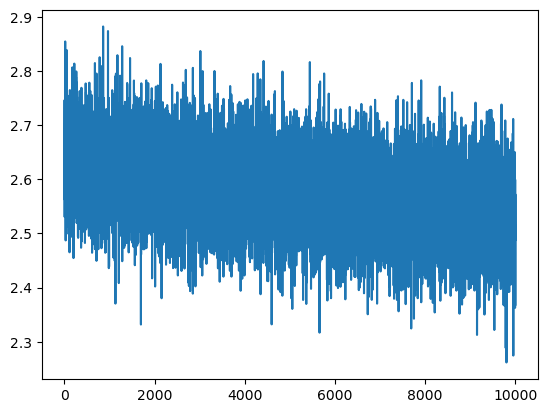

In [34]:
import matplotlib.pyplot as plt

plt.plot(loss_progress)

In [36]:
# Lets do some predictions
# Start by feeding some input (get some index)
idx = torch.zeros((1,1), dtype=torch.long, device=device)
generate_values = m.generate(index=idx, max_new_tokens=500)
print(charwise_decoder(generate_values[0].tolist()))


t, ter trof*Cd—y.
cl hathjghele[DPsen,”
j?”
“Neve r cPaisigr oed Mind gows y tht aj3forous hf y kofisotori2ld5s.” a heistind, icar ringun p wnKéwe anlf k’HxêC“ENe w keyond wd’s ok Th*—shy, s.”
qus*ind in t ke U:
itthencsldintinto. t msede pe themssl, s wo’siveswnd non t’s ce uns y-eat plig’vem, hewhear an]N?--I’d hasO’s is mak1s k tsooI lyot(é(-cormbunt I ofisy.
y wGof y bs, kely she tabane Ts Ganrr wse s angowash


I’shinfe ant q)pham Wc—avid
pU’s sid lis classhele
sthiongaisule chur we a pous.
